FLIGHT DIFFICULTY - OPERATIONAL INSIGHTS ANALYSIS
Loaded 8099 flights from ../outputs/flight_difficulty_scores.csv

DESTINATION DIFFICULTY ANALYSIS

TOP 10 MOST DIFFICULT DESTINATIONS:
destination  avg_difficulty  flight_count  avg_delay_min  avg_weighted_bags
        BRU           21.18            15          42.67             636.90
        GRU           19.50            15          67.93             535.87
        HNL           13.57            15          12.73             371.97
        HND           13.08            18           5.94             538.31
        FRA           12.27            30          52.57             364.70
        ATH           10.48            15          15.53             296.80
        KEF            7.00            15          35.33             269.07
        CDG            6.96            15          54.67             150.43
        FAI            6.63            15          11.13             268.07
        MXP            6.55            15          37.1

/var/folders/1c/vd0n01815sq9yfg19swh9n340000gn/T/ipykernel_10300/4026120228.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  driver_comparison = destination_analysis.groupby("dest_category").agg({


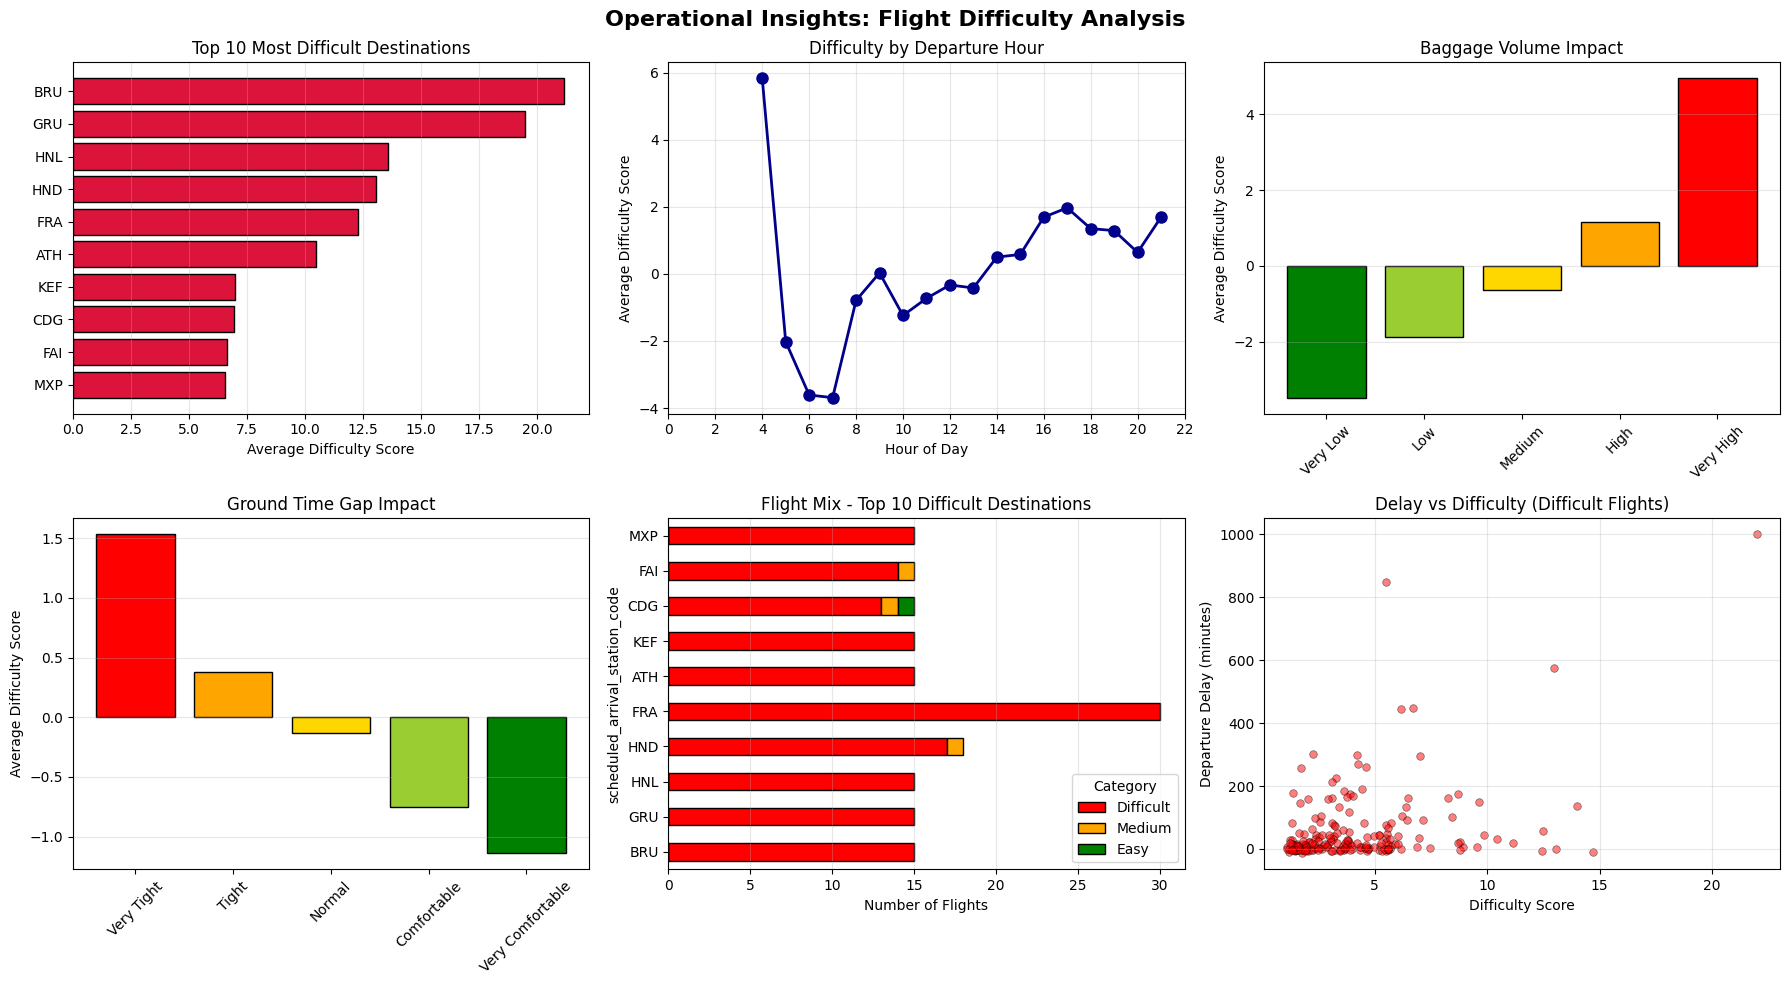


Visualization saved to: ../outputs/operational_insights.png

SAVING RESULTS

Destination analysis saved to: ../outputs/destination_difficulty_analysis.csv
Recommendations saved to: ../outputs/operational_recommendations.csv

ANALYSIS COMPLETE


In [1]:
"""
Flight Difficulty - Operational Insights and Recommendations
Standalone analysis script to identify patterns and actionable recommendations
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
INPUT_FILE = "../outputs/flight_difficulty_scores.csv"
OUTPUT_DIR = "../outputs"

def load_data():
    """Load the difficulty scores from previous analysis"""
    if not os.path.exists(INPUT_FILE):
        raise FileNotFoundError(
            f"Required file not found: {INPUT_FILE}\n"
            "Please run the main difficulty scoring script first."
        )
    
    daily = pd.read_csv(INPUT_FILE)
    
    # Convert date columns if needed
    if 'flight_date' in daily.columns:
        daily['flight_date'] = pd.to_datetime(daily['flight_date'])
    
    print(f"Loaded {len(daily)} flights from {INPUT_FILE}")
    return daily


def analyze_destinations(daily):
    """Analyze which destinations are most difficult"""
    print("\n" + "="*80)
    print("DESTINATION DIFFICULTY ANALYSIS")
    print("="*80)
    
    destination_analysis = (
        daily
        .groupby("scheduled_arrival_station_code")
        .agg({
            "difficulty_score": ["mean", "median", "std"],
            "flight_number": "count",
            "departure_delay": "mean",
            "ground_time_gap": "mean",
            "weighted_baggage": "mean",
            "total_pax": "mean",
            "special_needs_pax": "mean"
        })
        .round(2)
    )
    
    # Flatten column names
    destination_analysis.columns = ['_'.join(col).strip() for col in destination_analysis.columns]
    destination_analysis = destination_analysis.reset_index()
    destination_analysis.columns = [
        "destination", "avg_difficulty", "median_difficulty", "std_difficulty",
        "flight_count", "avg_delay_min", "avg_ground_gap_min", 
        "avg_weighted_bags", "avg_passengers", "avg_special_needs"
    ]
    
    # Sort by average difficulty
    destination_analysis = destination_analysis.sort_values("avg_difficulty", ascending=False)
    
    # Categorize destinations
    destination_analysis["dest_category"] = pd.qcut(
        destination_analysis["avg_difficulty"],
        q=3,
        labels=["Low_Difficulty", "Medium_Difficulty", "High_Difficulty"]
    )
    
    print(f"\nTOP 10 MOST DIFFICULT DESTINATIONS:")
    print(destination_analysis.head(10)[["destination", "avg_difficulty", "flight_count", 
                                          "avg_delay_min", "avg_weighted_bags"]].to_string(index=False))
    
    print(f"\nTOP 10 EASIEST DESTINATIONS:")
    print(destination_analysis.tail(10)[["destination", "avg_difficulty", "flight_count", 
                                          "avg_delay_min", "avg_weighted_bags"]].to_string(index=False))
    
    return destination_analysis


def analyze_drivers(destination_analysis):
    """Identify common drivers of difficulty"""
    print("\n" + "="*80)
    print("DIFFICULTY DRIVERS BY DESTINATION CATEGORY")
    print("="*80)
    
    driver_comparison = destination_analysis.groupby("dest_category").agg({
        "avg_delay_min": "mean",
        "avg_ground_gap_min": "mean",
        "avg_weighted_bags": "mean",
        "avg_passengers": "mean",
        "avg_special_needs": "mean"
    }).round(2)
    
    print("\nAVERAGE METRICS BY DESTINATION DIFFICULTY TIER:")
    print(driver_comparison.to_string())
    
    # Calculate percentage differences
    if len(driver_comparison) >= 2:
        baseline = driver_comparison.iloc[0]  # Low difficulty
        high_diff = driver_comparison.iloc[-1]  # High difficulty
        
        print("\nKEY DIFFERENCES (High Difficulty vs Low Difficulty Destinations):")
        for col in driver_comparison.columns:
            if baseline[col] != 0:
                pct_change = ((high_diff[col] - baseline[col]) / abs(baseline[col])) * 100
                direction = "higher" if pct_change > 0 else "lower"
                print(f"   {col}: {abs(pct_change):.1f}% {direction}")
    
    return driver_comparison


def analyze_time_patterns(daily):
    """Analyze time-of-day patterns"""
    print("\n" + "="*80)
    print("TIME-OF-DAY ANALYSIS")
    print("="*80)
    
    time_analysis = (
        daily
        .groupby("departure_hour")
        .agg({
            "difficulty_score": "mean",
            "flight_number": "count",
            "departure_delay": "mean",
            "ground_time_gap": "mean"
        })
        .round(2)
        .reset_index()
    )
    
    time_analysis.columns = ["hour", "avg_difficulty", "flight_count", "avg_delay", "avg_ground_gap"]
    time_analysis = time_analysis.sort_values("avg_difficulty", ascending=False)
    
    print("\nMOST DIFFICULT TIME PERIODS:")
    print(time_analysis.head(5).to_string(index=False))
    
    print("\nEASIEST TIME PERIODS:")
    print(time_analysis.tail(5).to_string(index=False))
    
    return time_analysis


def analyze_baggage_impact(daily):
    """Analyze baggage complexity impact"""
    print("\n" + "="*80)
    print("BAGGAGE COMPLEXITY ANALYSIS")
    print("="*80)
    
    if daily["weighted_baggage"].sum() == 0:
        print("\nNo baggage data available for analysis")
        return None
    
    baggage_quartiles = daily["weighted_baggage"].quantile([0.25, 0.75])
    
    high_bag_flights = daily[daily["weighted_baggage"] >= baggage_quartiles[0.75]]
    low_bag_flights = daily[daily["weighted_baggage"] <= baggage_quartiles[0.25]]
    
    print(f"\nHIGH BAGGAGE FLIGHTS (Top 25%):")
    print(f"   Count: {len(high_bag_flights)} flights")
    print(f"   Average difficulty score: {high_bag_flights['difficulty_score'].mean():.2f}")
    print(f"   Average weighted bags: {high_bag_flights['weighted_baggage'].mean():.0f}")
    print(f"   Average delay: {high_bag_flights['departure_delay'].mean():.1f} min")
    
    print(f"\nLOW BAGGAGE FLIGHTS (Bottom 25%):")
    print(f"   Count: {len(low_bag_flights)} flights")
    print(f"   Average difficulty score: {low_bag_flights['difficulty_score'].mean():.2f}")
    print(f"   Average weighted bags: {low_bag_flights['weighted_baggage'].mean():.0f}")
    print(f"   Average delay: {low_bag_flights['departure_delay'].mean():.1f} min")
    
    bag_impact = high_bag_flights['difficulty_score'].mean() - low_bag_flights['difficulty_score'].mean()
    print(f"\nBaggage impact on difficulty: {bag_impact:+.2f} score points")
    
    return {"high": high_bag_flights, "low": low_bag_flights, "impact": bag_impact}


def analyze_ground_time(daily):
    """Analyze ground time pressure"""
    print("\n" + "="*80)
    print("GROUND TIME PRESSURE ANALYSIS")
    print("="*80)
    
    tight_turns = daily[daily["ground_time_gap"] < daily["ground_time_gap"].quantile(0.25)]
    comfortable_turns = daily[daily["ground_time_gap"] > daily["ground_time_gap"].quantile(0.75)]
    
    print(f"\nTIGHT TURNAROUNDS (Bottom 25% ground time):")
    print(f"   Count: {len(tight_turns)} flights")
    print(f"   Average difficulty score: {tight_turns['difficulty_score'].mean():.2f}")
    print(f"   Average ground time gap: {tight_turns['ground_time_gap'].mean():.1f} min")
    print(f"   Average delay: {tight_turns['departure_delay'].mean():.1f} min")
    
    print(f"\nCOMFORTABLE TURNAROUNDS (Top 25% ground time):")
    print(f"   Count: {len(comfortable_turns)} flights")
    print(f"   Average difficulty score: {comfortable_turns['difficulty_score'].mean():.2f}")
    print(f"   Average ground time gap: {comfortable_turns['ground_time_gap'].mean():.1f} min")
    print(f"   Average delay: {comfortable_turns['departure_delay'].mean():.1f} min")
    
    return {"tight": tight_turns, "comfortable": comfortable_turns}


def generate_recommendations(daily, destination_analysis, time_analysis, ground_analysis):
    """Generate actionable operational recommendations"""
    print("\n" + "="*80)
    print("OPERATIONAL RECOMMENDATIONS")
    print("="*80)
    
    # Identify critical segments
    high_diff_dests = destination_analysis[
        destination_analysis["dest_category"] == "High_Difficulty"
    ]["destination"].tolist()
    
    difficult_hours = time_analysis.head(3)["hour"].tolist()
    tight_turns = ground_analysis["tight"]
    
    high_transfer_flights = daily[daily["weighted_baggage"] > daily["weighted_baggage"].quantile(0.8)] \
        if daily["weighted_baggage"].sum() > 0 else pd.DataFrame()
    
    high_special_needs = daily[daily["special_needs_pax"] > daily["special_needs_pax"].quantile(0.75)] \
        if daily["special_needs_pax"].sum() > 0 else pd.DataFrame()
    
    recommendations = []
    
    # 1. Staffing
    print(f"\n1. STAFFING ALLOCATION:")
    print(f"   Action: Deploy additional ground crew for high-difficulty destinations")
    print(f"   Scope: {len(high_diff_dests)} destinations")
    print(f"   Priority destinations: {', '.join(high_diff_dests[:5])}")
    print(f"   Affected flights: {len(daily[daily['scheduled_arrival_station_code'].isin(high_diff_dests)])}")
    
    recommendations.append({
        "Category": "Staffing",
        "Priority": "High",
        "Affected_Flights": len(daily[daily["scheduled_arrival_station_code"].isin(high_diff_dests)]),
        "Action": "Deploy additional ground crew for high-difficulty destinations",
        "Destinations": ", ".join(high_diff_dests[:5])
    })
    
    # 2. Baggage
    if len(high_transfer_flights) > 0:
        print(f"\n2. BAGGAGE HANDLING:")
        print(f"   Action: Pre-position transfer bag handlers for high-volume flights")
        print(f"   Scope: {len(high_transfer_flights)} flights")
        print(f"   Implementation: Deploy dedicated teams 30 minutes before arrival")
        
        recommendations.append({
            "Category": "Baggage",
            "Priority": "High",
            "Affected_Flights": len(high_transfer_flights),
            "Action": "Pre-position transfer bag handlers",
            "Implementation": "Deploy 30 min before arrival"
        })
    
    # 3. Schedule
    print(f"\n3. SCHEDULE OPTIMIZATION:")
    print(f"   Action: Add buffer time for tight turnarounds to difficult destinations")
    print(f"   Scope: {len(tight_turns)} flights with tight turns")
    print(f"   Current avg gap: {tight_turns['ground_time_gap'].mean():.0f} minutes")
    print(f"   Recommended minimum: {tight_turns['ground_time_gap'].mean() + 15:.0f} minutes")
    
    recommendations.append({
        "Category": "Schedule",
        "Priority": "Medium",
        "Affected_Flights": len(tight_turns),
        "Action": "Add 15-minute buffer to tight turnarounds",
        "Current_Avg": f"{tight_turns['ground_time_gap'].mean():.0f} min"
    })
    
    # 4. Time-based
    print(f"\n4. TIME-BASED RESOURCE PLANNING:")
    print(f"   Action: Increase staffing during peak difficulty hours")
    print(f"   Hours: {difficult_hours}")
    print(f"   Affected flights: {len(daily[daily['departure_hour'].isin(difficult_hours)])}")
    
    recommendations.append({
        "Category": "Time-Based",
        "Priority": "Medium",
        "Affected_Flights": len(daily[daily["departure_hour"].isin(difficult_hours)]),
        "Action": "Increase staffing during peak hours",
        "Hours": str(difficult_hours)
    })
    
    # 5. Special needs
    if len(high_special_needs) > 0:
        print(f"\n5. SPECIAL NEEDS SUPPORT:")
        print(f"   Action: Enhanced passenger assistance for families/children")
        print(f"   Scope: {len(high_special_needs)} flights")
        print(f"   Implementation: Pre-assign family boarding coordinators")
        
        recommendations.append({
            "Category": "Special Needs",
            "Priority": "Medium",
            "Affected_Flights": len(high_special_needs),
            "Action": "Pre-assign family boarding coordinators",
            "Implementation": "Priority boarding support"
        })
    
    # 6. Monitoring
    alert_threshold = daily["difficulty_score"].quantile(0.75)
    high_risk_flights = daily[daily["difficulty_score"] > alert_threshold]
    
    print(f"\n6. PROACTIVE MONITORING:")
    print(f"   Action: Implement real-time difficulty score dashboard")
    print(f"   Alert threshold: Difficulty score > {alert_threshold:.2f}")
    print(f"   Daily high-risk flights: ~{len(high_risk_flights)}")
    print(f"   Recommendation: Morning briefing on top 10 difficult flights")
    
    recommendations.append({
        "Category": "Monitoring",
        "Priority": "High",
        "Affected_Flights": len(high_risk_flights),
        "Action": "Real-time difficulty monitoring dashboard",
        "Alert_Threshold": f">{alert_threshold:.2f}"
    })
    
    return pd.DataFrame(recommendations)


def calculate_impact(daily):
    """Calculate expected impact of recommendations"""
    print("\n" + "="*80)
    print("EXPECTED IMPACT ANALYSIS")
    print("="*80)
    
    avg_delay_difficult = daily[daily["category"] == "Difficult"]["departure_delay"].mean()
    avg_delay_easy = daily[daily["category"] == "Easy"]["departure_delay"].mean()
    delay_gap = avg_delay_difficult - avg_delay_easy
    
    difficult_count = len(daily[daily["category"] == "Difficult"])
    
    print(f"\nCurrent Performance Gap:")
    print(f"   Difficult flights avg delay: {avg_delay_difficult:.1f} minutes")
    print(f"   Easy flights avg delay: {avg_delay_easy:.1f} minutes")
    print(f"   Gap: {delay_gap:.1f} minutes")
    
    print(f"\nPotential Improvements (30% delay reduction for difficult flights):")
    print(f"   Delay reduction per flight: {delay_gap * 0.3:.1f} minutes")
    print(f"   Total difficult flights: {difficult_count}")
    print(f"   Total time saved: {(delay_gap * 0.3 * difficult_count) / 60:.1f} hours")
    
    print(f"\nOperational Benefits:")
    print(f"   - Reduced gate holds and taxi delays")
    print(f"   - Improved on-time performance")
    print(f"   - Better crew utilization")
    print(f"   - Enhanced passenger experience")
    print(f"   - Lower risk of missed connections")


def create_visualizations(daily, destination_analysis, time_analysis):
    """Create comprehensive visualization dashboard"""
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Operational Insights: Flight Difficulty Analysis", fontsize=16, fontweight="bold")
    
    # Plot 1: Top destinations
    top_dests = destination_analysis.head(10)
    axes[0, 0].barh(range(len(top_dests)), top_dests["avg_difficulty"], color="crimson", edgecolor="black")
    axes[0, 0].set_yticks(range(len(top_dests)))
    axes[0, 0].set_yticklabels(top_dests["destination"])
    axes[0, 0].set_xlabel("Average Difficulty Score")
    axes[0, 0].set_title("Top 10 Most Difficult Destinations")
    axes[0, 0].grid(alpha=0.3, axis='x')
    axes[0, 0].invert_yaxis()
    
    # Plot 2: Time of day
    time_sorted = time_analysis.sort_values("hour")
    axes[0, 1].plot(time_sorted["hour"], time_sorted["avg_difficulty"], 
                    marker='o', linewidth=2, color="darkblue", markersize=8)
    axes[0, 1].set_xlabel("Hour of Day")
    axes[0, 1].set_ylabel("Average Difficulty Score")
    axes[0, 1].set_title("Difficulty by Departure Hour")
    axes[0, 1].grid(alpha=0.3)
    axes[0, 1].set_xticks(range(0, 24, 2))
    
    # Plot 3: Baggage impact
    if daily["weighted_baggage"].sum() > 0:
        baggage_bins = pd.qcut(daily["weighted_baggage"], q=5, duplicates='drop',
                               labels=["Very Low", "Low", "Medium", "High", "Very High"])
        bag_impact_df = daily.groupby(baggage_bins, observed=True)["difficulty_score"].mean()
        axes[0, 2].bar(range(len(bag_impact_df)), bag_impact_df.values, 
                       color=["green", "yellowgreen", "gold", "orange", "red"], edgecolor="black")
        axes[0, 2].set_xticks(range(len(bag_impact_df)))
        axes[0, 2].set_xticklabels(bag_impact_df.index, rotation=45)
        axes[0, 2].set_ylabel("Average Difficulty Score")
        axes[0, 2].set_title("Baggage Volume Impact")
        axes[0, 2].grid(alpha=0.3, axis='y')
    else:
        axes[0, 2].text(0.5, 0.5, "No baggage data", ha='center', va='center')
        axes[0, 2].set_title("Baggage Volume Impact")
    
    # Plot 4: Ground time impact
    ground_bins = pd.qcut(daily["ground_time_gap"], q=5, duplicates='drop',
                          labels=["Very Tight", "Tight", "Normal", "Comfortable", "Very Comfortable"])
    ground_impact_df = daily.groupby(ground_bins, observed=True)["difficulty_score"].mean()
    axes[1, 0].bar(range(len(ground_impact_df)), ground_impact_df.values,
                   color=["red", "orange", "gold", "yellowgreen", "green"], edgecolor="black")
    axes[1, 0].set_xticks(range(len(ground_impact_df)))
    axes[1, 0].set_xticklabels(ground_impact_df.index, rotation=45)
    axes[1, 0].set_ylabel("Average Difficulty Score")
    axes[1, 0].set_title("Ground Time Gap Impact")
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # Plot 5: Category mix
    category_by_dest = daily.groupby(["scheduled_arrival_station_code", "category"], observed=True).size().unstack(fill_value=0)
    top_10_dests = destination_analysis.head(10)["destination"].tolist()
    category_subset = category_by_dest.loc[top_10_dests]
    category_subset = category_subset[["Difficult", "Medium", "Easy"]]
    category_subset.plot(kind="barh", stacked=True, ax=axes[1, 1], 
                        color=["red", "orange", "green"], edgecolor="black")
    axes[1, 1].set_xlabel("Number of Flights")
    axes[1, 1].set_title("Flight Mix - Top 10 Difficult Destinations")
    axes[1, 1].legend(title="Category", loc="lower right")
    axes[1, 1].grid(alpha=0.3, axis='x')
    
    # Plot 6: Delay correlation
    difficult_subset = daily[daily["category"] == "Difficult"].sample(min(200, len(daily[daily["category"] == "Difficult"])))
    axes[1, 2].scatter(difficult_subset["difficulty_score"], difficult_subset["departure_delay"],
                       alpha=0.5, color="red", s=30, edgecolor="black", linewidth=0.5)
    axes[1, 2].set_xlabel("Difficulty Score")
    axes[1, 2].set_ylabel("Departure Delay (minutes)")
    axes[1, 2].set_title("Delay vs Difficulty (Difficult Flights)")
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    output_path = os.path.join(OUTPUT_DIR, "operational_insights.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to: {output_path}")


def save_results(destination_analysis, recommendations):
    """Save analysis results to CSV files"""
    print("\n" + "="*80)
    print("SAVING RESULTS")
    print("="*80)
    
    # Save destination analysis
    dest_path = os.path.join(OUTPUT_DIR, "destination_difficulty_analysis.csv")
    destination_analysis.to_csv(dest_path, index=False)
    print(f"\nDestination analysis saved to: {dest_path}")
    
    # Save recommendations
    rec_path = os.path.join(OUTPUT_DIR, "operational_recommendations.csv")
    recommendations.to_csv(rec_path, index=False)
    print(f"Recommendations saved to: {rec_path}")


def main():
    """Main analysis workflow"""
    print("="*80)
    print("FLIGHT DIFFICULTY - OPERATIONAL INSIGHTS ANALYSIS")
    print("="*80)
    
    # Load data
    daily = load_data()
    
    # Run analyses
    destination_analysis = analyze_destinations(daily)
    analyze_drivers(destination_analysis)
    time_analysis = analyze_time_patterns(daily)
    analyze_baggage_impact(daily)
    ground_analysis = analyze_ground_time(daily)
    
    # Generate recommendations
    recommendations = generate_recommendations(daily, destination_analysis, time_analysis, ground_analysis)
    
    # Calculate impact
    calculate_impact(daily)
    
    # Create visualizations
    create_visualizations(daily, destination_analysis, time_analysis)
    
    # Save results
    save_results(destination_analysis, recommendations)
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)


if __name__ == "__main__":
    main()